<a href="https://colab.research.google.com/github/ThodupunooriSaiManish/Machine_Learning/blob/main/ML_Assignment2_205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/ML_Lab/jm1.csv')
print(data.columns)

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')


In [10]:
# Replace '?' with NaN for pandas to recognize missing values
import numpy as np

data.replace('?', np.nan, inplace=True)

# Convert all columns to numeric (force errors to NaN)
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Now handle missing values by imputation or dropping rows with NaN
# Option 1: Drop rows with any missing value
data.dropna(inplace=True)

# Option 2: (recommended) fill missing values, e.g., with column mean
# for col in feature_cols:
#     data[col].fillna(data[col].mean(), inplace=True)

# Proceed with feature and target extraction again
X = data[feature_cols]
y = data[target_col]

# Normalize features and continue as before
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Replacing '?' with NaN for missing value handling
data.replace('?', np.nan, inplace=True)

# Columns based on dataset
feature_cols = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
                'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd',
                'total_Op', 'total_Opnd', 'branchCount']
target_col = 'defects'

# Converting features to numeric, coercing errors
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Dropping rows with missing values
data.dropna(inplace=True)

# Extracting features and target
X = data[feature_cols]
y = data[target_col].astype(int)  # Ensure target is integer (0 or 1)

# Normalizing features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Handling class imbalance using NearMiss under-sampling on training data
nm = NearMiss()
X_train_bal, y_train_bal = nm.fit_resample(X_train, y_train)

In [15]:
# Initial Random Forest model training
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predictions & probabilities
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Initial model performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Corr Coef:", matthews_corrcoef(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Initial model performance:
Accuracy: 0.3938419117647059
Precision: 0.22787878787878788
Recall: 0.8931116389548693
F1 Score: 0.3631096088845968
Matthews Corr Coef: 0.15425666078185335
ROC AUC: 0.6457248039195782


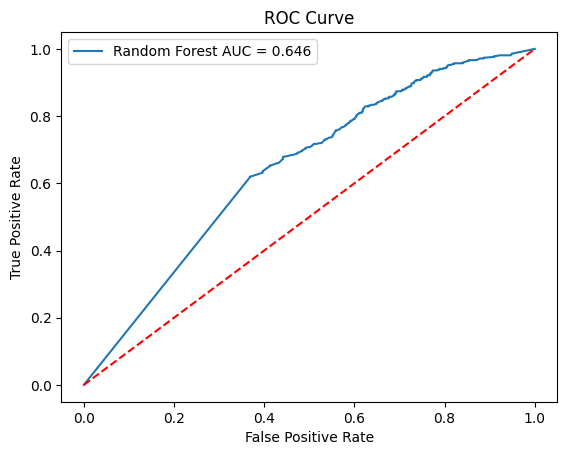

In [17]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="Random Forest AUC = %0.3f" % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [18]:
# Hyperparameter tuning with GridSearchCV (fixed max_features)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']  # Removed 'auto'
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                           cv=3, scoring='roc_auc', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_bal, y_train_bal)

print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}


In [19]:
# Train best estimator and evaluate
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_bal, y_train_bal)
y_pred_tuned = best_rf.predict(X_test)
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]

print("Tuned model performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall:", recall_score(y_test, y_pred_tuned))
print("F1 Score:", f1_score(y_test, y_pred_tuned))
print("Matthews Corr Coef:", matthews_corrcoef(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_prob_tuned))

Tuned model performance:
Accuracy: 0.40441176470588236
Precision: 0.2287662740235586
Recall: 0.8764845605700713
F1 Score: 0.36283185840707965
Matthews Corr Coef: 0.15122328021268103
ROC AUC: 0.6366756670794675


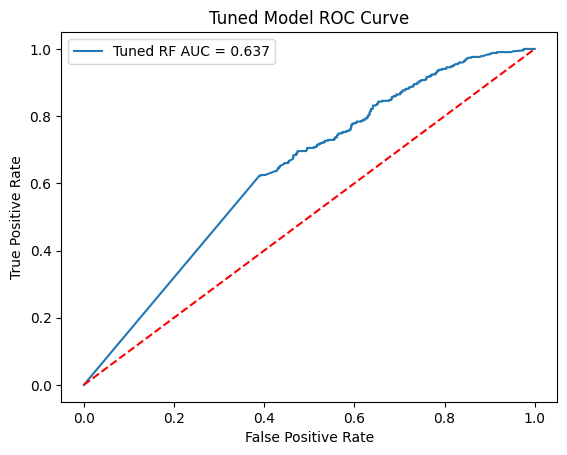

In [20]:
# Plot tuned model ROC Curve
fpr2, tpr2, _ = roc_curve(y_test, y_prob_tuned)
plt.plot(fpr2, tpr2, label="Tuned RF AUC = %0.3f" % roc_auc_score(y_test, y_prob_tuned))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tuned Model ROC Curve")
plt.legend()
plt.show()